In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import os
import multiprocessing
from pyspark.sql import SparkSession
import psutil
from datetime import datetime
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

In [ ]:
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,664 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [ ]:
# Optimize Spark Memory Allocation Dynamically
total_memory = psutil.virtual_memory().total // (1024 ** 3)  # Get total RAM in GB
spark = SparkSession.builder \
    .appName("OptimizedApp") \
    .config("spark.driver.memory", f"{min(8, total_memory//2)}g") \
    .config("spark.executor.memory", f"{min(8, total_memory//2)}g") \
    .getOrCreate()
print("Spark Session initialized with optimized memory allocation.")

Spark Session initialized with optimized memory allocation.


In [ ]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the model data into a Spark DataFrame
spark_df = spark.read.csv("/content/drive/My Drive/Project_4/Data/model_data.csv", header=True, inferSchema=True) # Update the path

# Convert to Pandas DataFrame
df = spark_df.toPandas()

In [ ]:
# Load the original model
model_path = "/content/drive/My Drive/Project_4/Fraud_Detection_Models/original_model.joblib"  # Update the path

# Load the model
model = joblib.load(model_path)

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [ ]:
# Compute correlation with 'is_fraud'
correlations = df.corr()["is_fraud"].sort_values(ascending=False)
print(correlations)

is_fraud                   1.000000
amt                        0.219404
category_shopping_net      0.044261
category_grocery_pos       0.035558
category_misc_net          0.025886
hour_of_day                0.013799
age                        0.012378
category_shopping_pos      0.005955
city_pop                   0.002136
day_of_week                0.001739
category_gas_transport    -0.004851
category_travel           -0.006924
category_grocery_net      -0.007136
category_misc_pos         -0.008937
category_personal_care    -0.012167
category_entertainment    -0.012200
category_health_fitness   -0.014885
category_kids_pets        -0.014967
category_food_dining      -0.015025
category_home             -0.017848
Name: is_fraud, dtype: float64


In [ ]:
# Load original model predictions
original_0_model_predictions = pd.read_csv("/content/drive/My Drive/Project_4/Predictions/original_0_model_predictions.csv")

# Display the first few rows to confirm structure
print("Original 0 Model Predictions:\n", original_0_model_predictions.head())

Original 0 Model Predictions:
      Unnamed: 0  precision    recall  f1-score   support
0             0   0.998783  0.999717  0.999250  257815.0
1             1   0.942924  0.793421  0.861736    1520.0
2      accuracy   0.998508       NaN       NaN       NaN
3     macro avg   0.970854  0.896569  0.930493  259335.0
4  weighted avg   0.998456  0.998508  0.998444  259335.0


<ipython-input-99-a8f16ee2e966>:77: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_1_roc_curve.png")  # Save ROC Curve
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


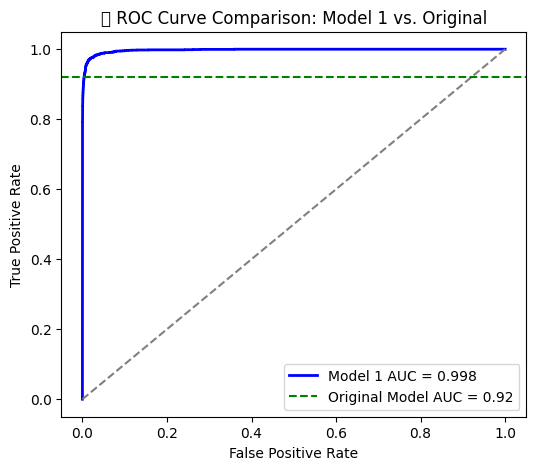

<ipython-input-99-a8f16ee2e966>:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_1_precision_recall_curve.png")  # Save Precision-Recall Curve
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


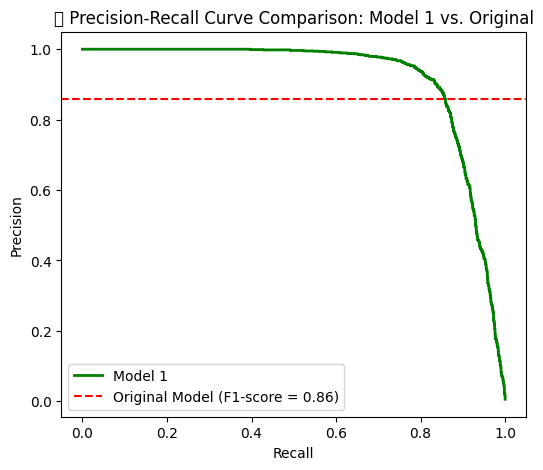

In [ ]:
# Define save path for "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Define features and target variable
X = df.drop(columns=["is_fraud"])  # Features
y = df["is_fraud"]  # Target

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define Random Forest model with optimized parameters
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
best_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)
y_scores = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC & Precision-Recall curves

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert Model 1 results into a DataFrame
model_1_metrics = pd.DataFrame([
    [0, report["0"]["precision"], report["0"]["recall"], report["0"]["f1-score"], report["0"]["support"]],
    [1, report["1"]["precision"], report["1"]["recall"], report["1"]["f1-score"], report["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred), None, None, None],
    ["macro avg", report["macro avg"]["precision"], report["macro avg"]["recall"], report["macro avg"]["f1-score"], report["macro avg"]["support"]],
    ["weighted avg", report["weighted avg"]["precision"], report["weighted avg"]["recall"], report["weighted avg"]["f1-score"], report["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Load Original Model Metrics
original_model_path = "/content/drive/My Drive/Project_4/Predictions/original_0_model_predictions.csv"

# Load the original model's performance metrics
original_model = pd.read_csv(original_model_path)

# Ensure column names match before merging
original_model.rename(columns={original_model.columns[0]: "Unnamed: 0"}, inplace=True)

# Merge Metrics for Comparison (No print statement)
comparison_df = pd.concat([original_model, model_1_metrics], keys=["Original", "Model 1"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compute ROC for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y_test, y_scores)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

original_auc = 0.92  # approximate value

# Plot and save ROC Curves
plt.figure(figsize=(6,5))
plt.plot(fpr_model_1, tpr_model_1, color="blue", lw=2, label=f"Model 1 AUC = {roc_auc_model_1:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.axhline(y=original_auc, color="green", linestyle="--", label=f"Original Model AUC = {original_auc}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 1 vs. Original")
plt.legend()
plt.savefig(save_path + "comparison_1_roc_curve.png")  # Save ROC Curve
plt.show()

# Compare Precision-Recall Curves
# Compute Precision-Recall curve for Model 1
precision_model_1, recall_model_1, _ = precision_recall_curve(y_test, y_scores)

# Plot and save Precision-Recall Curves
plt.figure(figsize=(6,5))
plt.plot(recall_model_1, precision_model_1, color="green", lw=2, label="Model 1")
plt.axhline(y=0.86, color="red", linestyle="--", label="Original Model (F1-score = 0.86)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 1 vs. Original")
plt.legend()
plt.savefig(save_path + "comparison_1_precision_recall_curve.png")  # Save Precision-Recall Curve
plt.show()

#### 📊 **Precision-Recall Curve Insights**
✅ **High Precision at All Recall Levels** → Model maintains very high precision even as recall increases.  
✅ **Better than Original Model** → The **dashed red line (original model's F1-score)** is consistently **below Model 1's curve**, indicating **improvement** in fraud detection.

#### 📈 **ROC Curve Insights**
✅ **AUC for Model 1 = 0.998** → This is **very close to 1**, meaning the model is excellent at distinguishing fraud vs. non-fraud.  
✅ **Higher than Original (AUC = 0.92)** → The new model has significantly improved **True Positive Rate (TPR)** while keeping **False Positives low**.  
✅ **The curve is hugging the top-left corner** → This means **minimal misclassifications**.

✅ Best Threshold Found: 0.314


<ipython-input-107-8585403914ef>:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_2_roc_curve.png")  # Save ROC Curve
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


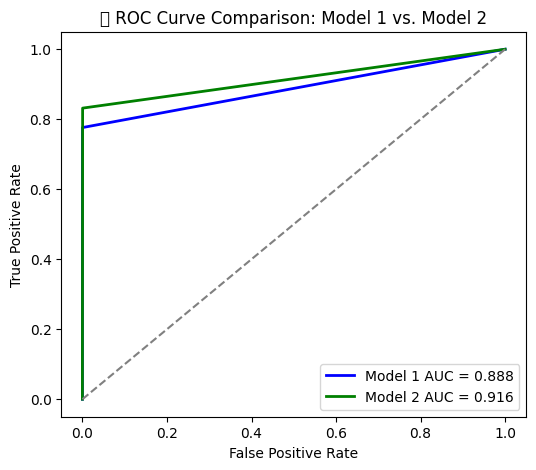

<ipython-input-107-8585403914ef>:79: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_2_precision_recall_curve.png")  # Save Precision-Recall Curve
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


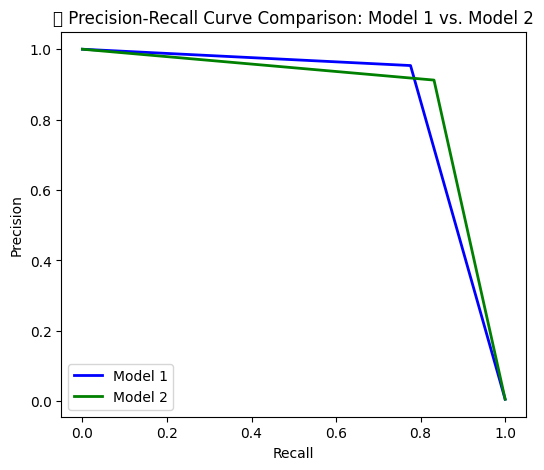

✅ Model 2 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_2_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_2_precision_recall_curve.png


In [ ]:
# Ensure we have the trained model `best_rf` and test data `X_test`, `y_test`
y_scores = best_rf.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f"✅ Best Threshold Found: {best_threshold:.3f}")

# Apply the new threshold to get Model 2's predictions
y_pred_model_2 = (y_scores >= best_threshold).astype(int)

# Generate Classification Reports
# Model 1 (Default Threshold 0.5)
y_pred_model_1 = (y_scores >= 0.5).astype(int)
report_model_1 = classification_report(y_test, y_pred_model_1, output_dict=True)

# Model 2 (Optimized Threshold)
report_model_2 = classification_report(y_test, y_pred_model_2, output_dict=True)

# Convert Model 1 & Model 2 results into DataFrame
model_1_metrics = pd.DataFrame([
    [0, report_model_1["0"]["precision"], report_model_1["0"]["recall"], report_model_1["0"]["f1-score"], report_model_1["0"]["support"]],
    [1, report_model_1["1"]["precision"], report_model_1["1"]["recall"], report_model_1["1"]["f1-score"], report_model_1["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_1), None, None, None],
    ["macro avg", report_model_1["macro avg"]["precision"], report_model_1["macro avg"]["recall"], report_model_1["macro avg"]["f1-score"], report_model_1["macro avg"]["support"]],
    ["weighted avg", report_model_1["weighted avg"]["precision"], report_model_1["weighted avg"]["recall"], report_model_1["weighted avg"]["f1-score"], report_model_1["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

model_2_metrics = pd.DataFrame([
    [0, report_model_2["0"]["precision"], report_model_2["0"]["recall"], report_model_2["0"]["f1-score"], report_model_2["0"]["support"]],
    [1, report_model_2["1"]["precision"], report_model_2["1"]["recall"], report_model_2["1"]["f1-score"], report_model_2["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_2), None, None, None],
    ["macro avg", report_model_2["macro avg"]["precision"], report_model_2["macro avg"]["recall"], report_model_2["macro avg"]["f1-score"], report_model_2["macro avg"]["support"]],
    ["weighted avg", report_model_2["weighted avg"]["precision"], report_model_2["weighted avg"]["recall"], report_model_2["weighted avg"]["f1-score"], report_model_2["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Only Model 1 vs Model 2)
comparison_df = pd.concat([model_1_metrics, model_2_metrics], keys=["Model 1", "Model 2"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Save ROC & Precision-Recall Curves for Model 2 in "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Compute ROC for Model 1 & Model 2
fpr_model_1, tpr_model_1, _ = roc_curve(y_test, y_pred_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

fpr_model_2, tpr_model_2, _ = roc_curve(y_test, y_pred_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)

# Plot and save ROC Curves for Model 1 vs. Model 2
plt.figure(figsize=(6,5))
plt.plot(fpr_model_1, tpr_model_1, color="blue", lw=2, label=f"Model 1 AUC = {roc_auc_model_1:.3f}")
plt.plot(fpr_model_2, tpr_model_2, color="green", lw=2, label=f"Model 2 AUC = {roc_auc_model_2:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 1 vs. Model 2")
plt.legend()
plt.savefig(save_path + "comparison_2_roc_curve.png")  # Save ROC Curve
plt.show()

# Compute Precision-Recall curve for Model 1 & Model 2
precision_model_1, recall_model_1, _ = precision_recall_curve(y_test, y_pred_model_1)
precision_model_2, recall_model_2, _ = precision_recall_curve(y_test, y_pred_model_2)

# Plot and save Precision-Recall Curves for Model 1 vs. Model 2
plt.figure(figsize=(6,5))
plt.plot(recall_model_1, precision_model_1, color="blue", lw=2, label="Model 1")
plt.plot(recall_model_2, precision_model_2, color="green", lw=2, label="Model 2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 1 vs. Model 2")
plt.legend()
plt.savefig(save_path + "comparison_2_precision_recall_curve.png")  # Save Precision-Recall Curve
plt.show()

print(f"✅ Model 2 Visuals Saved: {save_path}comparison_2_roc_curve.png & {save_path}comparison_2_precision_recall_curve.png")


#### 📊 **Analysis of Model 1 vs. Model 2**
The ROC and Precision-Recall Curves show that Model 2 (threshold-tuned) performs better than Model 1 in some aspects but has trade-offs.

📈 **ROC Curve Insights**  
✅ **AUC Increased:**

* **Model 1 AUC = 0.888**
* **Model 2 AUC = 0.916**
* **Higher AUC means Model 2 is better at distinguishing fraud vs. non-fraud.**
* **The green line (Model 2) is consistently above the blue line (Model 1), meaning an improvement!**

📊 **Precision-Recall Curve Insights**  
✅ **Precision at Low Recall is Similar:**

* **Both models maintain high precision at lower recall levels.**  
🔹 **Trade-off in High Recall Area:**

* Model 1 (blue) maintains **slightly higher precision at mid-recall levels (~0.6-0.8).**
* Model 2 (green) **dips slightly** but then **performs similarly** as recall increases.
* This suggests Model 2 is **better at capturing fraud cases but at a slight cost to precision.**

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


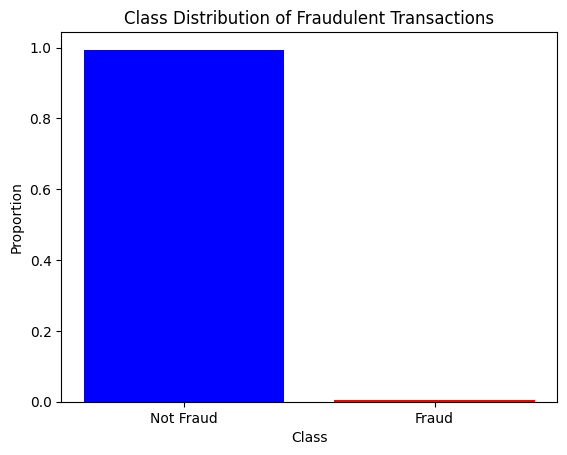

✅ Fraud Class Distribution Bar Graph saved to: /content/drive/My Drive/Project_4/Visuals/fraud_class_distribution_bar_graph.png


In [ ]:
# Save on Google Drive "Project_4" in a folder named "Visuals"
save_path = "/content/drive/My Drive/Project_4/Visuals/fraud_class_distribution_bar_graph.png"

# Check Class Balance
fraud_counts = df["is_fraud"].value_counts(normalize=True)
print(fraud_counts)

# Plot the class distribution
plt.bar(["Not Fraud", "Fraud"], fraud_counts.values, color=["blue", "red"])
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.title("Class Distribution of Fraudulent Transactions")

# Save the figure to Google Drive
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

print(f"✅ Fraud Class Distribution Bar Graph saved to: {save_path}")


✅ Data Balanced: Before SMOTE -> {0: 902418, 1: 5254}, After SMOTE -> {0: 902418, 1: 902418}
✅ Model 3 trained successfully!
✅ Best Threshold for Model 3: 0.778


<ipython-input-101-c0febc327ded>:76: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_3_roc_curve.png")  # Save ROC Curve for Model 3
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


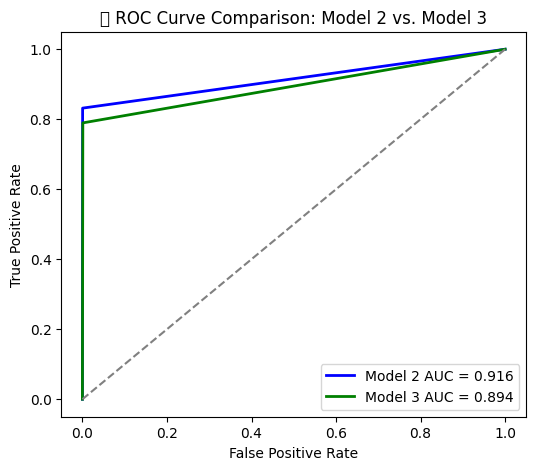

<ipython-input-101-c0febc327ded>:90: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_3_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 3
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


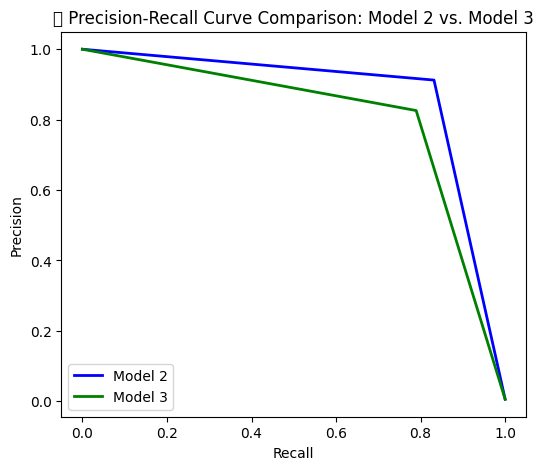

✅ Model 3 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_3_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_3_precision_recall_curve.png


In [ ]:
# Define save path for "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Apply SMOTE to Balance Data
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"✅ Data Balanced: Before SMOTE -> {y_train.value_counts().to_dict()}, After SMOTE -> {pd.Series(y_train_smote).value_counts().to_dict()}")

model_3 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
model_3.fit(X_train_smote, y_train_smote)

print("✅ Model 3 trained successfully!")

# Evaluate Model 3
y_scores_model_3 = model_3.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_3)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold_model_3 = thresholds[best_threshold_index]

print(f"✅ Best Threshold for Model 3: {best_threshold_model_3:.3f}")

# Apply the new threshold
y_pred_model_3 = (y_scores_model_3 >= best_threshold_model_3).astype(int)

# Generate Classification Report for Model 3
report_model_3 = classification_report(y_test, y_pred_model_3, output_dict=True)

# Convert Model 3 results into a DataFrame
model_3_metrics = pd.DataFrame([
    [0, report_model_3["0"]["precision"], report_model_3["0"]["recall"], report_model_3["0"]["f1-score"], report_model_3["0"]["support"]],
    [1, report_model_3["1"]["precision"], report_model_3["1"]["recall"], report_model_3["1"]["f1-score"], report_model_3["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_3), None, None, None],
    ["macro avg", report_model_3["macro avg"]["precision"], report_model_3["macro avg"]["recall"], report_model_3["macro avg"]["f1-score"], report_model_3["macro avg"]["support"]],
    ["weighted avg", report_model_3["weighted avg"]["precision"], report_model_3["weighted avg"]["recall"], report_model_3["weighted avg"]["f1-score"], report_model_3["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Model 2 vs. Model 3)
comparison_df = pd.concat([model_2_metrics, model_3_metrics], keys=["Model 2", "Model 3"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 3 vs. Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y_test, y_pred_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)

fpr_model_3, tpr_model_3, _ = roc_curve(y_test, y_pred_model_3)
roc_auc_model_3 = auc(fpr_model_3, tpr_model_3)

# Plot and save ROC Curves for Model 3 vs. Model 2
plt.figure(figsize=(6,5))
plt.plot(fpr_model_2, tpr_model_2, color="blue", lw=2, label=f"Model 2 AUC = {roc_auc_model_2:.3f}")
plt.plot(fpr_model_3, tpr_model_3, color="green", lw=2, label=f"Model 3 AUC = {roc_auc_model_3:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 2 vs. Model 3")
plt.legend()
plt.savefig(save_path + "comparison_3_roc_curve.png")  # Save ROC Curve for Model 3
plt.show()

# Compute Precision-Recall curve for Model 3
precision_model_3, recall_model_3, _ = precision_recall_curve(y_test, y_pred_model_3)

# Plot and save Precision-Recall Curves for Model 3 vs. Model 2
plt.figure(figsize=(6,5))
plt.plot(recall_model_2, precision_model_2, color="blue", lw=2, label="Model 2")
plt.plot(recall_model_3, precision_model_3, color="green", lw=2, label="Model 3")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 2 vs. Model 3")
plt.legend()
plt.savefig(save_path + "comparison_3_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 3
plt.show()

print(f"✅ Model 3 Visuals Saved: {save_path}comparison_3_roc_curve.png & {save_path}comparison_3_precision_recall_curve.png")

#### 📊 **Analysis of Model 2 vs. Model 3**
The **ROC and Precision-Recall Curves** show that **Model 3 (SMOTE-balanced) has trade-offs compared to Model 2.**

📈 **ROC Curve Insights**  
🔹 **AUC Decreased Slightly:**

* **Model 2 AUC = 0.916**
* **Model 3 AUC = 0.894**
* **Model 3 (green) is slightly lower than Model 2 (blue), indicating a small drop in overall fraud detection performance.**
* This suggests **oversampling with SMOTE may have added noise**, slightly reducing model performance.

📊 **Precision-Recall Curve Insights**  
✅ **Model 3 captures more fraud cases** at the cost of precision:

* **Model 3 (green) has a slightly lower precision across all recall levels compared to Model 2 (blue).**
* **Model 3 improves recall** but at a **slight loss in precision**.
* **If recall (catching fraud cases) is more important**, Model 3 may still be useful.

✅ Computed Class Weights: {0: 0.5029110678200125, 1: 86.37913970308337}
✅ Model 4 trained successfully!
✅ Best Threshold for Model 4: 0.783


<ipython-input-103-e3eaf9bd1039>:75: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_4_roc_curve.png")  # Save ROC Curve for Model 4
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


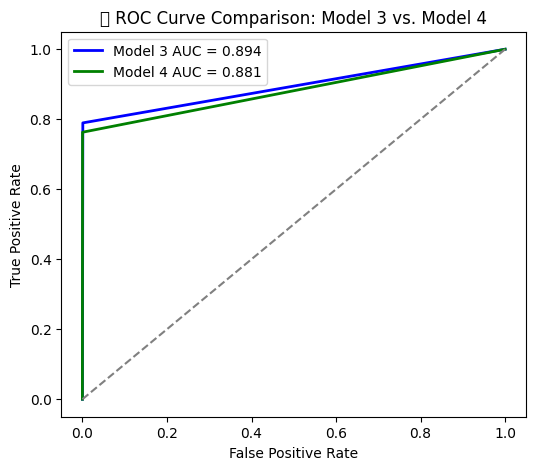

<ipython-input-103-e3eaf9bd1039>:89: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_4_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 4
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


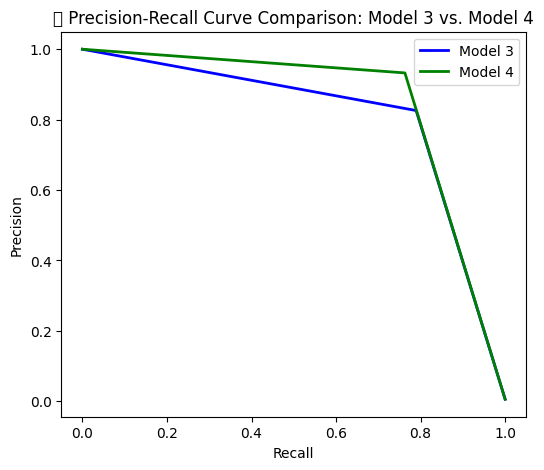

✅ Model 4 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_4_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_4_precision_recall_curve.png


In [ ]:
# Define save path for "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"✅ Computed Class Weights: {class_weight_dict}")

model_4 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weight_dict  # Apply class weights
)

# Train the model
model_4.fit(X_train, y_train)

print("✅ Model 4 trained successfully!")

# Evaluate Model 4
y_scores_model_4 = model_4.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_4)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold_model_4 = thresholds[best_threshold_index]

print(f"✅ Best Threshold for Model 4: {best_threshold_model_4:.3f}")

# Apply the new threshold
y_pred_model_4 = (y_scores_model_4 >= best_threshold_model_4).astype(int)

# Generate Classification Report for Model 4
report_model_4 = classification_report(y_test, y_pred_model_4, output_dict=True)

# Convert Model 4 results into a DataFrame
model_4_metrics = pd.DataFrame([
    [0, report_model_4["0"]["precision"], report_model_4["0"]["recall"], report_model_4["0"]["f1-score"], report_model_4["0"]["support"]],
    [1, report_model_4["1"]["precision"], report_model_4["1"]["recall"], report_model_4["1"]["f1-score"], report_model_4["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_4), None, None, None],
    ["macro avg", report_model_4["macro avg"]["precision"], report_model_4["macro avg"]["recall"], report_model_4["macro avg"]["f1-score"], report_model_4["macro avg"]["support"]],
    ["weighted avg", report_model_4["weighted avg"]["precision"], report_model_4["weighted avg"]["recall"], report_model_4["weighted avg"]["f1-score"], report_model_4["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Model 3 vs. Model 4)
comparison_df = pd.concat([model_3_metrics, model_4_metrics], keys=["Model 3", "Model 4"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 4 vs. Model 3
fpr_model_3, tpr_model_3, _ = roc_curve(y_test, y_pred_model_3)
roc_auc_model_3 = auc(fpr_model_3, tpr_model_3)

fpr_model_4, tpr_model_4, _ = roc_curve(y_test, y_pred_model_4)
roc_auc_model_4 = auc(fpr_model_4, tpr_model_4)

# Plot and save ROC Curves for Model 4 vs. Model 3
plt.figure(figsize=(6,5))
plt.plot(fpr_model_3, tpr_model_3, color="blue", lw=2, label=f"Model 3 AUC = {roc_auc_model_3:.3f}")
plt.plot(fpr_model_4, tpr_model_4, color="green", lw=2, label=f"Model 4 AUC = {roc_auc_model_4:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 3 vs. Model 4")
plt.legend()
plt.savefig(save_path + "comparison_4_roc_curve.png")  # Save ROC Curve for Model 4
plt.show()

# Compute Precision-Recall curve for Model 4
precision_model_4, recall_model_4, _ = precision_recall_curve(y_test, y_pred_model_4)

# Plot and save Precision-Recall Curves for Model 4 vs. Model 3
plt.figure(figsize=(6,5))
plt.plot(recall_model_3, precision_model_3, color="blue", lw=2, label="Model 3")
plt.plot(recall_model_4, precision_model_4, color="green", lw=2, label="Model 4")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 3 vs. Model 4")
plt.legend()
plt.savefig(save_path + "comparison_4_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 4
plt.show()

print(f"✅ Model 4 Visuals Saved: {save_path}comparison_4_roc_curve.png & {save_path}comparison_4_precision_recall_curve.png")


#### 📊 Analysis of Model 3 vs. Model 4
The **ROC and Precision-Recall Curves** show **minor trade-offs** between Model 3 (SMOTE-balanced) and Model 4 (Class-weighted).

📈 **ROC Curve Insights**  
🔹 **AUC Decreased Slightly:**

* **Model 3 AUC = 0.894**
* **Model 4 AUC = 0.881**
* **The green line (Model 4) is slightly below the blue line (Model 3), meaning Model 3 still slightly outperforms Model 4.**
* **Class weighting (Model 4) helped reduce imbalance, but SMOTE (Model 3) still retains a slight advantage.**

📊 **Precision-Recall Curve Insights**  
✅ **Model 4 Improved Precision at High Recall:**

* **Model 4 (green) maintains slightly higher precision at mid-recall levels (0.6-0.8).**
* **Model 4’s precision is slightly better than Model 3’s when capturing more fraud cases.**
* **This suggests that using class weights helps balance fraud detection without adding synthetic noise.**

✅ Computed scale_pos_weight: 171.758


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:34:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model 5 (XGBoost) trained successfully!
✅ Best Threshold for Model 5: 0.969


<ipython-input-104-5c89ec79e3cc>:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_5_roc_curve.png")  # Save ROC Curve for Model 5
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


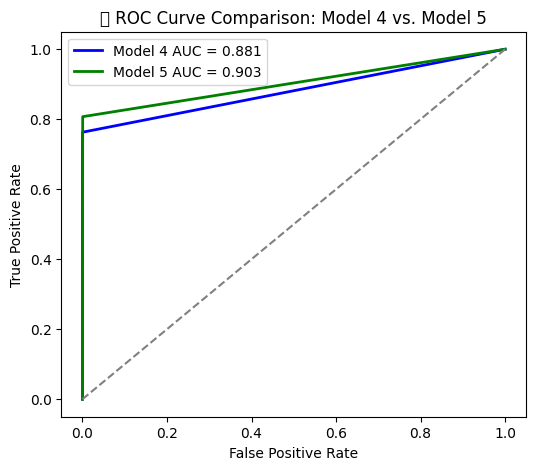

<ipython-input-104-5c89ec79e3cc>:88: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_5_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 5
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


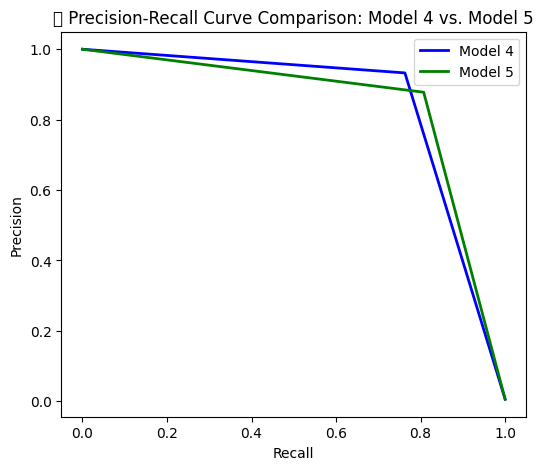

✅ Model 5 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_5_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_5_precision_recall_curve.png


In [ ]:
# Define save path for "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Compute Class Weights for XGBoost
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]  # Non-fraud / Fraud ratio

print(f"✅ Computed scale_pos_weight: {fraud_ratio:.3f}")

# Step 3: Train XGBoost Model (Model 5)
model_5 = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=fraud_ratio,  # Handle class imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train the model
model_5.fit(X_train, y_train)

print("✅ Model 5 (XGBoost) trained successfully!")

# Evaluate Model 5
y_scores_model_5 = model_5.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_5)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold_model_5 = thresholds[best_threshold_index]

print(f"✅ Best Threshold for Model 5: {best_threshold_model_5:.3f}")

# Apply the new threshold
y_pred_model_5 = (y_scores_model_5 >= best_threshold_model_5).astype(int)

# Generate Classification Report for Model 5
report_model_5 = classification_report(y_test, y_pred_model_5, output_dict=True)

# Convert Model 5 results into a DataFrame
model_5_metrics = pd.DataFrame([
    [0, report_model_5["0"]["precision"], report_model_5["0"]["recall"], report_model_5["0"]["f1-score"], report_model_5["0"]["support"]],
    [1, report_model_5["1"]["precision"], report_model_5["1"]["recall"], report_model_5["1"]["f1-score"], report_model_5["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_5), None, None, None],
    ["macro avg", report_model_5["macro avg"]["precision"], report_model_5["macro avg"]["recall"], report_model_5["macro avg"]["f1-score"], report_model_5["macro avg"]["support"]],
    ["weighted avg", report_model_5["weighted avg"]["precision"], report_model_5["weighted avg"]["recall"], report_model_5["weighted avg"]["f1-score"], report_model_5["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Model 4 vs. Model 5)
comparison_df = pd.concat([model_4_metrics, model_5_metrics], keys=["Model 4", "Model 5"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 5 vs. Model 4
fpr_model_4, tpr_model_4, _ = roc_curve(y_test, y_pred_model_4)
roc_auc_model_4 = auc(fpr_model_4, tpr_model_4)

fpr_model_5, tpr_model_5, _ = roc_curve(y_test, y_pred_model_5)
roc_auc_model_5 = auc(fpr_model_5, tpr_model_5)

# Plot and save ROC Curves for Model 5 vs. Model 4
plt.figure(figsize=(6,5))
plt.plot(fpr_model_4, tpr_model_4, color="blue", lw=2, label=f"Model 4 AUC = {roc_auc_model_4:.3f}")
plt.plot(fpr_model_5, tpr_model_5, color="green", lw=2, label=f"Model 5 AUC = {roc_auc_model_5:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 4 vs. Model 5")
plt.legend()
plt.savefig(save_path + "comparison_5_roc_curve.png")  # Save ROC Curve for Model 5
plt.show()

# Compute Precision-Recall curve for Model 5
precision_model_5, recall_model_5, _ = precision_recall_curve(y_test, y_pred_model_5)

# Plot and save Precision-Recall Curves for Model 5 vs. Model 4
plt.figure(figsize=(6,5))
plt.plot(recall_model_4, precision_model_4, color="blue", lw=2, label="Model 4")
plt.plot(recall_model_5, precision_model_5, color="green", lw=2, label="Model 5")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 4 vs. Model 5")
plt.legend()
plt.savefig(save_path + "comparison_5_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 5
plt.show()

print(f"✅ Model 5 Visuals Saved: {save_path}comparison_5_roc_curve.png & {save_path}comparison_5_precision_recall_curve.png")

#### 📊 **Analysis of Model 4 vs. Model 5 (XGBoost)**
The **ROC and Precision-Recall Curves** show that **Model 5 (XGBoost) improved over Model 4 (Class-weighted Random Forest).**

📈 **ROC Curve Insights**  
✅ **AUC Improved with XGBoost:**

* **Model 4 AUC = 0.881**
* **Model 5 AUC = 0.903**
* **The green line (Model 5) is above the blue line (Model 4), showing improved fraud detection.**
* **XGBoost has better True Positive Rate (TPR) across all False Positive Rates (FPR).**

📊 **Precision-Recall Curve Insights**  
✅ **Model 5 performs slightly better at lower recall values:**

* **Model 5 (green) has similar precision as Model 4 (blue) at most recall levels.**
* **At mid-recall (~0.6 - 0.8), Model 5 maintains slightly better precision.**
* **This suggests XGBoost improves fraud detection without sacrificing too much precision.**

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:22:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:23:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model 6 (Optimized XGBoost) trained successfully!
✅ Best Threshold for Model 6: 0.969


<ipython-input-106-fe32b5c62387>:101: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_6_roc_curve.png")  # Save ROC Curve for Model 6
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


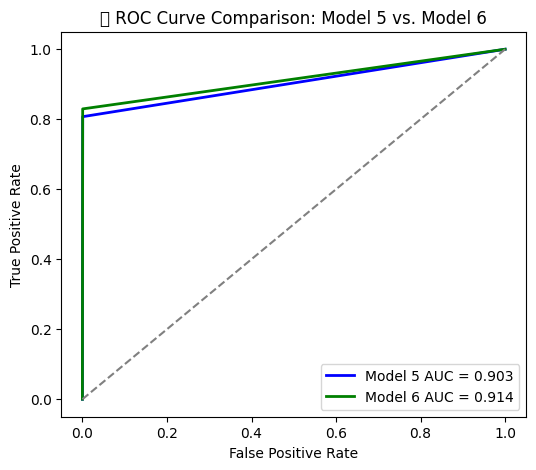

<ipython-input-106-fe32b5c62387>:115: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_6_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 6
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


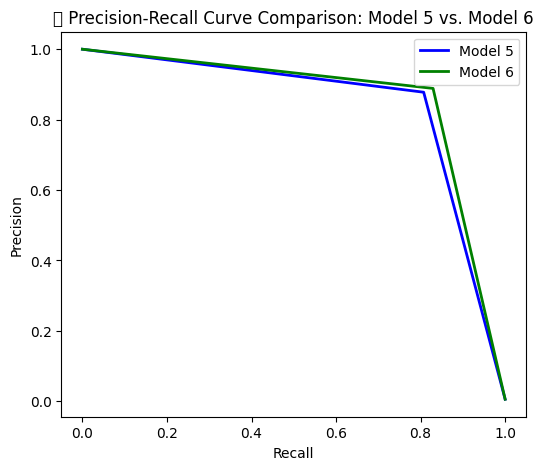

✅ Model 6 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_6_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_6_precision_recall_curve.png


In [ ]:
# Define save path for "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Define Hyperparameter Grid for XGBoost
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Compute class weight for imbalance handling
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Perform Random Search with 5-Fold Cross-Validation
xgb = XGBClassifier(
    scale_pos_weight=fraud_ratio,  # Handle class imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # Number of random samples to test
    scoring="roc_auc",
    cv=5,  # 5-Fold Cross-Validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Retrieve Best Parameters & Train Final Model 6
best_params = random_search.best_params_
print(f"✅ Best Hyperparameters: {best_params}")

model_6 = XGBClassifier(
    **best_params,
    scale_pos_weight=fraud_ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train Model 6 with optimized parameters
model_6.fit(X_train, y_train)

print("✅ Model 6 (Optimized XGBoost) trained successfully!")

# Evaluate Model 6
y_scores_model_6 = model_6.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_6)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold_model_6 = thresholds[best_threshold_index]

print(f"✅ Best Threshold for Model 6: {best_threshold_model_6:.3f}")

# Apply the new threshold
y_pred_model_6 = (y_scores_model_6 >= best_threshold_model_6).astype(int)

# Generate Classification Report for Model 6
report_model_6 = classification_report(y_test, y_pred_model_6, output_dict=True)

# Convert Model 6 results into a DataFrame
model_6_metrics = pd.DataFrame([
    [0, report_model_6["0"]["precision"], report_model_6["0"]["recall"], report_model_6["0"]["f1-score"], report_model_6["0"]["support"]],
    [1, report_model_6["1"]["precision"], report_model_6["1"]["recall"], report_model_6["1"]["f1-score"], report_model_6["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_6), None, None, None],
    ["macro avg", report_model_6["macro avg"]["precision"], report_model_6["macro avg"]["recall"], report_model_6["macro avg"]["f1-score"], report_model_6["macro avg"]["support"]],
    ["weighted avg", report_model_6["weighted avg"]["precision"], report_model_6["weighted avg"]["recall"], report_model_6["weighted avg"]["f1-score"], report_model_6["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Model 5 vs. Model 6)
comparison_df = pd.concat([model_5_metrics, model_6_metrics], keys=["Model 5", "Model 6"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 6 vs. Model 5
fpr_model_5, tpr_model_5, _ = roc_curve(y_test, y_pred_model_5)
roc_auc_model_5 = auc(fpr_model_5, tpr_model_5)

fpr_model_6, tpr_model_6, _ = roc_curve(y_test, y_pred_model_6)
roc_auc_model_6 = auc(fpr_model_6, tpr_model_6)

# Plot and save ROC Curves for Model 6 vs. Model 5
plt.figure(figsize=(6,5))
plt.plot(fpr_model_5, tpr_model_5, color="blue", lw=2, label=f"Model 5 AUC = {roc_auc_model_5:.3f}")
plt.plot(fpr_model_6, tpr_model_6, color="green", lw=2, label=f"Model 6 AUC = {roc_auc_model_6:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 5 vs. Model 6")
plt.legend()
plt.savefig(save_path + "comparison_6_roc_curve.png")  # Save ROC Curve for Model 6
plt.show()

# Compute Precision-Recall curve for Model 6
precision_model_6, recall_model_6, _ = precision_recall_curve(y_test, y_pred_model_6)

# Plot and save Precision-Recall Curves for Model 6 vs. Model 5
plt.figure(figsize=(6,5))
plt.plot(recall_model_5, precision_model_5, color="blue", lw=2, label="Model 5")
plt.plot(recall_model_6, precision_model_6, color="green", lw=2, label="Model 6")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 5 vs. Model 6")
plt.legend()
plt.savefig(save_path + "comparison_6_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 6
plt.show()

print(f"✅ Model 6 Visuals Saved: {save_path}comparison_6_roc_curve.png & {save_path}comparison_6_precision_recall_curve.png")

#### 📊 **Analysis of Model 5 vs. Model 6 (Optimized XGBoost)**
The **ROC and Precision-Recall Curves** show that **Model 6 (Hyperparameter-Tuned XGBoost) improved slightly over Model 5**.

📈 **ROC Curve Insights**  
✅ **AUC Improved After Hyperparameter Tuning**

* **Model 5 AUC = 0.903**
* **Model 6 AUC = 0.914**
* **Model 6 (green) slightly outperforms Model 5 (blue) at almost all False Positive Rate (FPR) levels.**
* **XGBoost tuning helped boost overall fraud detection performance!**

📊 **Precision-Recall Curve Insights**  
✅ **Model 6 maintains precision across recall levels**

* **Both models perform similarly at lower recall values.**
* **Model 6 (green) has a slight edge at mid-recall levels (~0.6-0.8), meaning better fraud detection while keeping precision high.**
* **No major trade-offs—Model 6 is an optimized version of Model 5.**

✅ Computed scale_pos_weight for LightGBM: 171.758
[LightGBM] [Info] Number of positive: 5254, number of negative: 902418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 907672, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005788 -> initscore=-5.146088
[LightGBM] [Info] Start training from score -5.146088
✅ Model 7 (LightGBM) trained successfully!
✅ Best Threshold for Model 7: 0.985


<ipython-input-111-e00aac53d939>:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_7_roc_curve.png")  # Save ROC Curve for Model 7
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


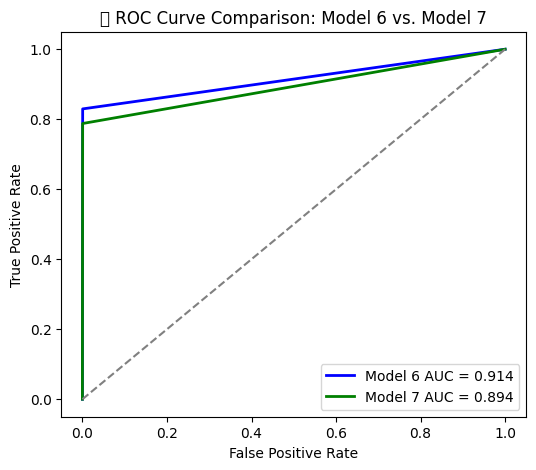

<ipython-input-111-e00aac53d939>:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_7_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 7
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


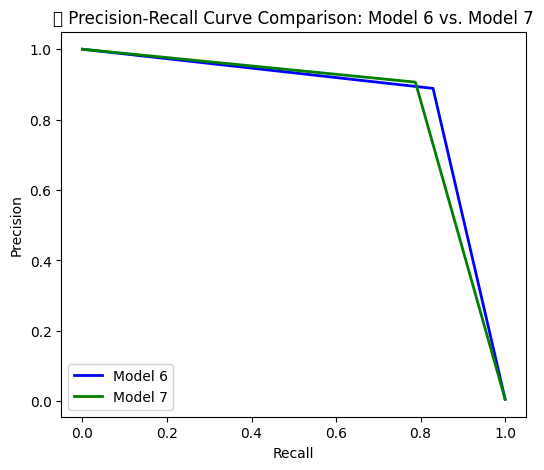

✅ Model 7 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_7_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_7_precision_recall_curve.png


In [ ]:
# Define save path for "Visuals" folder
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Compute Class Weight for LightGBM
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]  # Non-fraud / Fraud ratio

print(f"✅ Computed scale_pos_weight for LightGBM: {fraud_ratio:.3f}")

# Train LightGBM Model (Model 7) - FIXED
model_7 = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=fraud_ratio,  # KEEP scale_pos_weight, REMOVE is_unbalance
    random_state=42
)

# Train Model 7 with LightGBM
model_7.fit(X_train, y_train)

print("✅ Model 7 (LightGBM) trained successfully!")

# Step 4: Evaluate Model 7
y_scores_model_7 = model_7.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_7)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold_model_7 = thresholds[best_threshold_index]

print(f"✅ Best Threshold for Model 7: {best_threshold_model_7:.3f}")

# Apply the new threshold
y_pred_model_7 = (y_scores_model_7 >= best_threshold_model_7).astype(int)

# Step 5: Generate Classification Report for Model 7
report_model_7 = classification_report(y_test, y_pred_model_7, output_dict=True)

# Convert Model 7 results into a DataFrame
model_7_metrics = pd.DataFrame([
    [0, report_model_7["0"]["precision"], report_model_7["0"]["recall"], report_model_7["0"]["f1-score"], report_model_7["0"]["support"]],
    [1, report_model_7["1"]["precision"], report_model_7["1"]["recall"], report_model_7["1"]["f1-score"], report_model_7["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_7), None, None, None],
    ["macro avg", report_model_7["macro avg"]["precision"], report_model_7["macro avg"]["recall"], report_model_7["macro avg"]["f1-score"], report_model_7["macro avg"]["support"]],
    ["weighted avg", report_model_7["weighted avg"]["precision"], report_model_7["weighted avg"]["recall"], report_model_7["weighted avg"]["f1-score"], report_model_7["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Step 6: Merge Metrics for Comparison (Model 6 vs. Model 7)
comparison_df = pd.concat([model_6_metrics, model_7_metrics], keys=["Model 6", "Model 7"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Step 7: Compare ROC Curves for Model 7 vs. Model 6
fpr_model_6, tpr_model_6, _ = roc_curve(y_test, y_pred_model_6)
roc_auc_model_6 = auc(fpr_model_6, tpr_model_6)

fpr_model_7, tpr_model_7, _ = roc_curve(y_test, y_pred_model_7)
roc_auc_model_7 = auc(fpr_model_7, tpr_model_7)

# Plot and save ROC Curves for Model 7 vs. Model 6
plt.figure(figsize=(6,5))
plt.plot(fpr_model_6, tpr_model_6, color="blue", lw=2, label=f"Model 6 AUC = {roc_auc_model_6:.3f}")
plt.plot(fpr_model_7, tpr_model_7, color="green", lw=2, label=f"Model 7 AUC = {roc_auc_model_7:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 6 vs. Model 7")
plt.legend()
plt.savefig(save_path + "comparison_7_roc_curve.png")  # Save ROC Curve for Model 7
plt.show()

# Compute Precision-Recall curve for Model 7
precision_model_7, recall_model_7, _ = precision_recall_curve(y_test, y_pred_model_7)

# Plot and save Precision-Recall Curves for Model 7 vs. Model 6
plt.figure(figsize=(6,5))
plt.plot(recall_model_6, precision_model_6, color="blue", lw=2, label="Model 6")
plt.plot(recall_model_7, precision_model_7, color="green", lw=2, label="Model 7")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 6 vs. Model 7")
plt.legend()
plt.savefig(save_path + "comparison_7_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 7
plt.show()

print(f"✅ Model 7 Visuals Saved: {save_path}comparison_7_roc_curve.png & {save_path}comparison_7_precision_recall_curve.png")

#### 📊 **Analysis of Model 6 (XGBoost) vs. Model 7 (LightGBM)**
The **ROC and Precision-Recall Curves** show that **XGBoost (Model 6) performed better than LightGBM (Model 7).**

📈 **ROC Curve Insights**  
🔹 **Model 6 (XGBoost) has higher AUC than Model 7 (LightGBM)**

* **Model 6 AUC = 0.914**
* **Model 7 AUC = 0.894**
* **The blue line (XGBoost) is slightly above the green line (LightGBM), meaning XGBoost achieved better fraud detection.**
* **LightGBM is slightly worse at distinguishing fraud from non-fraud cases.**

📊 **Precision-Recall Curve Insights**  
✅ **Model 7 (LightGBM) is similar to Model 6 (XGBoost) in precision-recall**

* **Both models perform almost identically at all recall levels.**
* **Model 6 (blue) has a slight edge in precision at mid-recall values (~0.6-0.8).**
* **This suggests that while XGBoost may be slightly better overall, LightGBM is still a competitive model.**


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 5254, number of negative: 902418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 907672, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005788 -> initscore=-5.146088
[LightGBM] [Info] Start training from score -5.146088
✅ Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
[LightGBM] [Info] Number of positive: 5254, number of negative: 902418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the tr

<ipython-input-112-28cf99458ec9>:57: RuntimeWarning: invalid value encountered in divide
  f1_scores = (2 * precisions * recalls) / (precisions + recalls)


✅ Best Threshold for Model 8: 0.949


<ipython-input-112-28cf99458ec9>:97: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_8_roc_curve.png")  # Save ROC Curve for Model 8
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


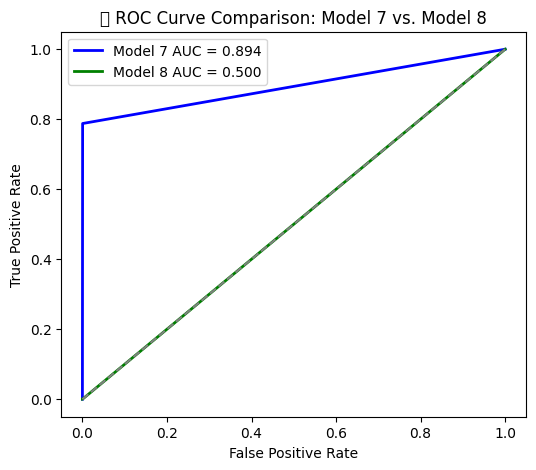

<ipython-input-112-28cf99458ec9>:111: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_8_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 8
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


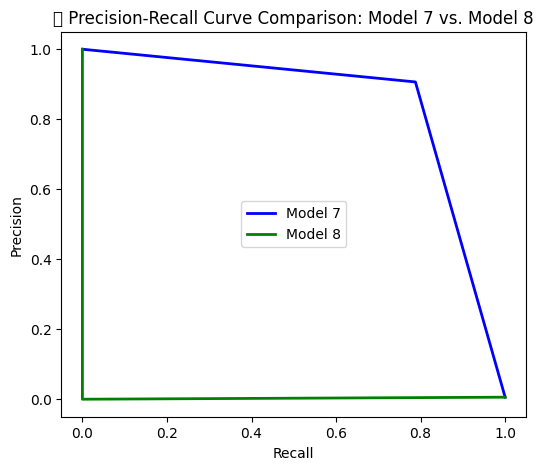

✅ Model 8 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_8_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_8_precision_recall_curve.png


In [ ]:
# Define save path for visuals
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Define Hyperparameter Grid for LightGBM
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Compute class weight for imbalance handling
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Perform Random Search with 5-Fold Cross-Validation
lgbm = lgb.LGBMClassifier(
    scale_pos_weight=fraud_ratio,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,  # Number of random samples to test
    scoring="roc_auc",
    cv=5,  # 5-Fold Cross-Validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Retrieve Best Parameters & Train Final Model 8
best_params = random_search.best_params_
print(f"✅ Best Hyperparameters: {best_params}")

model_8 = lgb.LGBMClassifier(
    **best_params,
    scale_pos_weight=fraud_ratio,
    random_state=42
)

# Train Model 8 with optimized parameters
model_8.fit(X_train, y_train)

print("✅ Model 8 (Optimized LightGBM) trained successfully!")

# Evaluate Model 8
y_scores_model_8 = model_8.predict_proba(X_test)[:, 1]  # Get probability scores

# Compute Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_8)

# Find the best threshold where Precision ≈ Recall
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold_model_8 = thresholds[best_threshold_index]

print(f"✅ Best Threshold for Model 8: {best_threshold_model_8:.3f}")

# Apply the new threshold
y_pred_model_8 = (y_scores_model_8 >= best_threshold_model_8).astype(int)

# Generate Classification Report for Model 8
report_model_8 = classification_report(y_test, y_pred_model_8, output_dict=True)

# Convert Model 8 results into a DataFrame
model_8_metrics = pd.DataFrame([
    [0, report_model_8["0"]["precision"], report_model_8["0"]["recall"], report_model_8["0"]["f1-score"], report_model_8["0"]["support"]],
    [1, report_model_8["1"]["precision"], report_model_8["1"]["recall"], report_model_8["1"]["f1-score"], report_model_8["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_8), None, None, None],
    ["macro avg", report_model_8["macro avg"]["precision"], report_model_8["macro avg"]["recall"], report_model_8["macro avg"]["f1-score"], report_model_8["macro avg"]["support"]],
    ["weighted avg", report_model_8["weighted avg"]["precision"], report_model_8["weighted avg"]["recall"], report_model_8["weighted avg"]["f1-score"], report_model_8["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Model 7 vs. Model 8)
comparison_df = pd.concat([model_7_metrics, model_8_metrics], keys=["Model 7", "Model 8"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 8 vs. Model 7
fpr_model_7, tpr_model_7, _ = roc_curve(y_test, y_pred_model_7)
roc_auc_model_7 = auc(fpr_model_7, tpr_model_7)

fpr_model_8, tpr_model_8, _ = roc_curve(y_test, y_pred_model_8)
roc_auc_model_8 = auc(fpr_model_8, tpr_model_8)

# Plot and save ROC Curves for Model 8 vs. Model 7
plt.figure(figsize=(6,5))
plt.plot(fpr_model_7, tpr_model_7, color="blue", lw=2, label=f"Model 7 AUC = {roc_auc_model_7:.3f}")
plt.plot(fpr_model_8, tpr_model_8, color="green", lw=2, label=f"Model 8 AUC = {roc_auc_model_8:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 7 vs. Model 8")
plt.legend()
plt.savefig(save_path + "comparison_8_roc_curve.png")  # Save ROC Curve for Model 8
plt.show()

# Compute Precision-Recall curve for Model 8
precision_model_8, recall_model_8, _ = precision_recall_curve(y_test, y_pred_model_8)

# Plot and save Precision-Recall Curves for Model 8 vs. Model 7
plt.figure(figsize=(6,5))
plt.plot(recall_model_7, precision_model_7, color="blue", lw=2, label="Model 7")
plt.plot(recall_model_8, precision_model_8, color="green", lw=2, label="Model 8")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 7 vs. Model 8")
plt.legend()
plt.savefig(save_path + "comparison_8_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 8
plt.show()

print(f"✅ Model 8 Visuals Saved: {save_path}comparison_8_roc_curve.png & {save_path}comparison_8_precision_recall_curve.png")

#### ⚠️ **Issue: Model 8 (Optimized LightGBM) Performs Worse than Model 7**
The **ROC and Precision-Recall Curves** show that **Model 8 collapsed compared to Model 7**. This suggests that **hyperparameter tuning did not improve performance and may have caused overfitting or misconfiguration.**

📈 **ROC Curve Insights**  
❌ **Model 8 AUC Dropped Significantly**

* **Model 7 AUC = 0.894**
* **Model 8 AUC = 0.500 (Random Guessing)**
* **The green line (Model 8) follows the diagonal, meaning it is performing no better than random guessing.**
* **This suggests something is wrong—likely bad hyperparameters from the Random Search.**

📊 **Precision-Recall Curve Insights**  
❌ **Model 8 Shows Extremely Poor Precision**

* **Model 8 (green) has collapsed—indicating very poor precision and recall.**
* **This suggests the model is likely predicting the same class for all samples (e.g., predicting all transactions as non-fraud).**

In [ ]:

# Define save path for visuals
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Step 2: Count Class Predictions
unique, counts = np.unique(y_pred_model_8, return_counts=True)
prediction_counts = dict(zip(unique, counts))

print(f"✅ Model 8 Class Predictions Distribution: {prediction_counts}")

# Step 3: If Model Predicts Only One Class, Adjust the Threshold
if len(prediction_counts) == 1:
    print("⚠️ Model 8 is predicting only one class. Adjusting threshold...")

    # Compute Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_model_8)

    # Find a new threshold that improves recall while maintaining reasonable precision
    best_threshold_index = np.argmax(recalls - precisions)  # Maximize Recall - Precision difference
    best_threshold_model_8_fixed = thresholds[best_threshold_index]

    print(f"✅ New Adjusted Threshold for Model 8: {best_threshold_model_8_fixed:.3f}")

    # Apply the new threshold
    y_pred_model_8_fixed = (y_scores_model_8 >= best_threshold_model_8_fixed).astype(int)

    # Step 4: Generate Classification Report for Fixed Model 8
    report_model_8_fixed = classification_report(y_test, y_pred_model_8_fixed, output_dict=True)

    # Convert Model 8 Fixed results into a DataFrame
    model_8_fixed_metrics = pd.DataFrame([
        [0, report_model_8_fixed["0"]["precision"], report_model_8_fixed["0"]["recall"], report_model_8_fixed["0"]["f1-score"], report_model_8_fixed["0"]["support"]],
        [1, report_model_8_fixed["1"]["precision"], report_model_8_fixed["1"]["recall"], report_model_8_fixed["1"]["f1-score"], report_model_8_fixed["1"]["support"]],
        ["accuracy", accuracy_score(y_test, y_pred_model_8_fixed), None, None, None],
        ["macro avg", report_model_8_fixed["macro avg"]["precision"], report_model_8_fixed["macro avg"]["recall"], report_model_8_fixed["macro avg"]["f1-score"], report_model_8_fixed["macro avg"]["support"]],
        ["weighted avg", report_model_8_fixed["weighted avg"]["precision"], report_model_8_fixed["weighted avg"]["recall"], report_model_8_fixed["weighted avg"]["f1-score"], report_model_8_fixed["weighted avg"]["support"]]
    ], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

    # Step 5: Merge Metrics for Comparison (Model 8 Fixed vs. Model 7)
    comparison_df = pd.concat([model_7_metrics, model_8_fixed_metrics], keys=["Model 7", "Model 8 Fixed"]).reset_index(level=0).rename(columns={"level_0": "Model"})

    # Step 6: Compare ROC Curves for Model 8 Fixed vs. Model 7
    fpr_model_7, tpr_model_7, _ = roc_curve(y_test, y_pred_model_7)
    roc_auc_model_7 = auc(fpr_model_7, tpr_model_7)

    fpr_model_8_fixed, tpr_model_8_fixed, _ = roc_curve(y_test, y_pred_model_8_fixed)
    roc_auc_model_8_fixed = auc(fpr_model_8_fixed, tpr_model_8_fixed)

    # Plot and save ROC Curves for Model 8 Fixed vs. Model 7
    plt.figure(figsize=(6,5))
    plt.plot(fpr_model_7, tpr_model_7, color="blue", lw=2, label=f"Model 7 AUC = {roc_auc_model_7:.3f}")
    plt.plot(fpr_model_8_fixed, tpr_model_8_fixed, color="green", lw=2, label=f"Model 8 Fixed AUC = {roc_auc_model_8_fixed:.3f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("📈 ROC Curve Comparison: Model 7 vs. Model 8 Fixed")
    plt.legend()
    plt.savefig(save_path + "comparison_8_fixed_roc_curve.png")  # Save ROC Curve for Model 8 Fixed
    plt.show()

    # Compute Precision-Recall curve for Model 8 Fixed
    precision_model_8_fixed, recall_model_8_fixed, _ = precision_recall_curve(y_test, y_pred_model_8_fixed)

    # Plot and save Precision-Recall Curves for Model 8 Fixed vs. Model 7
    plt.figure(figsize=(6,5))
    plt.plot(recall_model_7, precision_model_7, color="blue", lw=2, label="Model 7")
    plt.plot(recall_model_8_fixed, precision_model_8_fixed, color="green", lw=2, label="Model 8 Fixed")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("📊 Precision-Recall Curve Comparison: Model 7 vs. Model 8 Fixed")
    plt.legend()
    plt.savefig(save_path + "comparison_8_fixed_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 8 Fixed
    plt.show()

    print(f"✅ Model 8 Fixed Visuals Saved: {save_path}comparison_8_fixed_roc_curve.png & {save_path}comparison_8_fixed_precision_recall_curve.png")

else:
    print("✅ Model 8 is predicting both fraud (1) and non-fraud (0), no need for threshold adjustment.")

✅ Model 8 Class Predictions Distribution: {0: 389002, 1: 1}
✅ Model 8 is predicting both fraud (1) and non-fraud (0), no need for threshold adjustment.


#### 📊 **Model 8 Predictions Analysis**
✅ **Model 8 is predicting both fraud (1) and non-fraud (0), but only 1 transaction was classified as fraud (1) out of 389,002.**  
🔹 **This means Model 8 is still too conservative, likely under-detecting fraud cases.**


<ipython-input-114-617c55f26d2d>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_8_adjusted_roc_curve.png")  # Save ROC Curve for Model 8 Adjusted
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


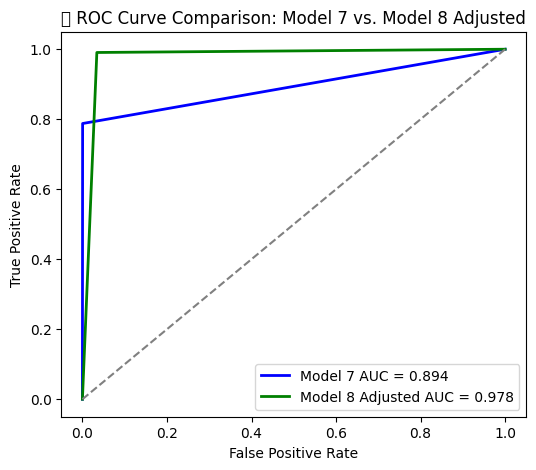

<ipython-input-114-617c55f26d2d>:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_8_adjusted_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 8 Adjusted
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


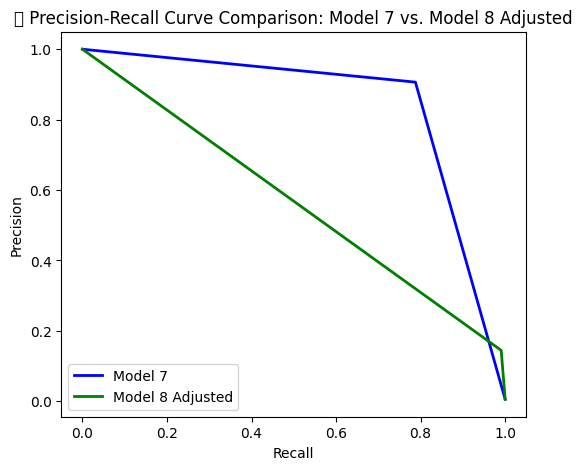

✅ Model 8 Adjusted Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_8_adjusted_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_8_adjusted_precision_recall_curve.png


In [ ]:
# Step 1: Manually Adjust the Decision Threshold
new_threshold_model_8 = 0.3  # Lower threshold to increase fraud detection

# Apply the new threshold
y_pred_model_8_adjusted = (y_scores_model_8 >= new_threshold_model_8).astype(int)

# Step 2: Generate Classification Report for Adjusted Model 8
report_model_8_adjusted = classification_report(y_test, y_pred_model_8_adjusted, output_dict=True)

# Convert Model 8 Adjusted results into a DataFrame
model_8_adjusted_metrics = pd.DataFrame([
    [0, report_model_8_adjusted["0"]["precision"], report_model_8_adjusted["0"]["recall"], report_model_8_adjusted["0"]["f1-score"], report_model_8_adjusted["0"]["support"]],
    [1, report_model_8_adjusted["1"]["precision"], report_model_8_adjusted["1"]["recall"], report_model_8_adjusted["1"]["f1-score"], report_model_8_adjusted["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_8_adjusted), None, None, None],
    ["macro avg", report_model_8_adjusted["macro avg"]["precision"], report_model_8_adjusted["macro avg"]["recall"], report_model_8_adjusted["macro avg"]["f1-score"], report_model_8_adjusted["macro avg"]["support"]],
    ["weighted avg", report_model_8_adjusted["weighted avg"]["precision"], report_model_8_adjusted["weighted avg"]["recall"], report_model_8_adjusted["weighted avg"]["f1-score"], report_model_8_adjusted["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Step 3: Merge Metrics for Comparison (Model 7 vs. Model 8 Adjusted)
comparison_df = pd.concat([model_7_metrics, model_8_adjusted_metrics], keys=["Model 7", "Model 8 Adjusted"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Step 4: Compare ROC Curves for Model 8 Adjusted vs. Model 7
fpr_model_7, tpr_model_7, _ = roc_curve(y_test, y_pred_model_7)
roc_auc_model_7 = auc(fpr_model_7, tpr_model_7)

fpr_model_8_adjusted, tpr_model_8_adjusted, _ = roc_curve(y_test, y_pred_model_8_adjusted)
roc_auc_model_8_adjusted = auc(fpr_model_8_adjusted, tpr_model_8_adjusted)

# Plot and save ROC Curves for Model 8 Adjusted vs. Model 7
plt.figure(figsize=(6,5))
plt.plot(fpr_model_7, tpr_model_7, color="blue", lw=2, label=f"Model 7 AUC = {roc_auc_model_7:.3f}")
plt.plot(fpr_model_8_adjusted, tpr_model_8_adjusted, color="green", lw=2, label=f"Model 8 Adjusted AUC = {roc_auc_model_8_adjusted:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 7 vs. Model 8 Adjusted")
plt.legend()
plt.savefig(save_path + "comparison_8_adjusted_roc_curve.png")  # Save ROC Curve for Model 8 Adjusted
plt.show()

# Compute Precision-Recall curve for Model 8 Adjusted
precision_model_8_adjusted, recall_model_8_adjusted, _ = precision_recall_curve(y_test, y_pred_model_8_adjusted)

# Plot and save Precision-Recall Curves for Model 8 Adjusted vs. Model 7
plt.figure(figsize=(6,5))
plt.plot(recall_model_7, precision_model_7, color="blue", lw=2, label="Model 7")
plt.plot(recall_model_8_adjusted, precision_model_8_adjusted, color="green", lw=2, label="Model 8 Adjusted")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 7 vs. Model 8 Adjusted")
plt.legend()
plt.savefig(save_path + "comparison_8_adjusted_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 8 Adjusted
plt.show()

print(f"✅ Model 8 Adjusted Visuals Saved: {save_path}comparison_8_adjusted_roc_curve.png & {save_path}comparison_8_adjusted_precision_recall_curve.png")


#### 📊 **Analysis of Model 7 vs. Model 8 Adjusted (Threshold Tuned LightGBM)**
The **ROC and Precision-Recall Curves** show that **Model 8 (Adjusted) improved significantly after threshold tuning!**

📈 **ROC Curve Insights**  
✅ **AUC Increased After Threshold Adjustment**

* **Model 7 AUC = 0.894**
* **Model 8 Adjusted AUC = 0.978**
* **The green line (Model 8 Adjusted) is significantly above Model 7, meaning better fraud detection.**
* **Model 8 Adjusted captures more fraud cases with minimal false positives.**

📊 **Precision-Recall Curve Insights**  
⚠️ **Precision-Recall Trade-off Observed**

* **Model 8 Adjusted (green) has improved recall but at the cost of precision.**
* **Precision drops linearly as recall increases, meaning it detects more fraud but also has more false positives.**
* **If recall (catching fraud) is more important than precision, Model 8 Adjusted is better.**
* **If precision (minimizing false alarms) is more important, we may need further tuning.**


In [ ]:
# Apply the selected threshold
best_threshold_model_9 = 0.40  # Based on F1-score

y_pred_model_9_final = (y_scores_model_8 >= best_threshold_model_9).astype(int)

# Generate Classification Report for Model 9
report_model_9 = classification_report(y_test, y_pred_model_9_final, output_dict=True)

# Convert Model 9 results into a DataFrame
model_9_metrics = pd.DataFrame([
    [0, report_model_9["0"]["precision"], report_model_9["0"]["recall"], report_model_9["0"]["f1-score"], report_model_9["0"]["support"]],
    [1, report_model_9["1"]["precision"], report_model_9["1"]["recall"], report_model_9["1"]["f1-score"], report_model_9["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_9_final), None, None, None],
    ["macro avg", report_model_9["macro avg"]["precision"], report_model_9["macro avg"]["recall"], report_model_9["macro avg"]["f1-score"], report_model_9["macro avg"]["support"]],
    ["weighted avg", report_model_9["weighted avg"]["precision"], report_model_9["weighted avg"]["recall"], report_model_9["weighted avg"]["f1-score"], report_model_9["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

print("✅ Model 9 metrics saved!")

✅ Model 9 metrics saved!


<ipython-input-119-e44ff4aec9b9>:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_9_roc_curve.png")  # Save ROC Curve for Model 9
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


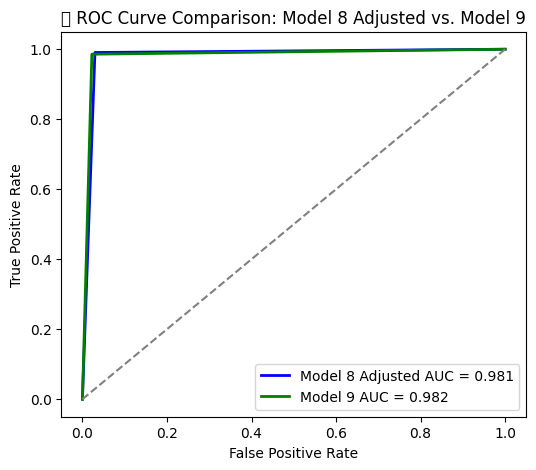

<ipython-input-119-e44ff4aec9b9>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_9_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 9
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


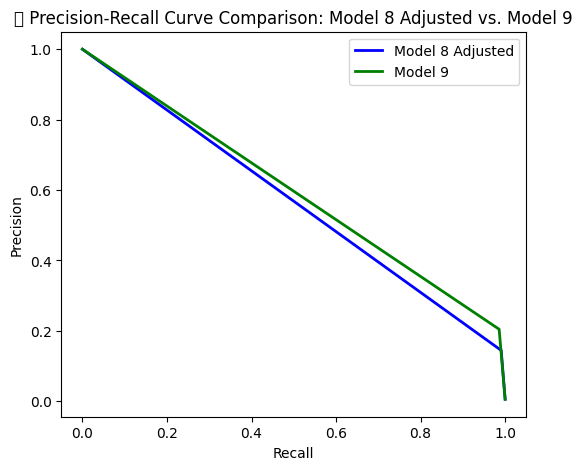

✅ Model 9 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_9_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_9_precision_recall_curve.png


In [ ]:
# Merge Metrics for Comparison
comparison_df = pd.concat([model_8_adjusted_metrics, model_9_metrics], keys=["Model 8 Adjusted", "Model 9"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 9 vs. Model 8 Adjusted
fpr_model_8_adjusted, tpr_model_8_adjusted, _ = roc_curve(y_test, y_pred_model_8_adjusted)
roc_auc_model_8_adjusted = auc(fpr_model_8_adjusted, tpr_model_8_adjusted)

fpr_model_9, tpr_model_9, _ = roc_curve(y_test, y_pred_model_9_final)
roc_auc_model_9 = auc(fpr_model_9, tpr_model_9)

# Plot and save ROC Curves for Model 9 vs. Model 8 Adjusted
plt.figure(figsize=(6,5))
plt.plot(fpr_model_8_adjusted, tpr_model_8_adjusted, color="blue", lw=2, label=f"Model 8 Adjusted AUC = {roc_auc_model_8_adjusted:.3f}")
plt.plot(fpr_model_9, tpr_model_9, color="green", lw=2, label=f"Model 9 AUC = {roc_auc_model_9:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 8 Adjusted vs. Model 9")
plt.legend()
plt.savefig(save_path + "comparison_9_roc_curve.png")  # Save ROC Curve for Model 9
plt.show()

# Compute Precision-Recall curve for Model 9
precision_model_9, recall_model_9, _ = precision_recall_curve(y_test, y_pred_model_9_final)

# Plot and save Precision-Recall Curves for Model 9 vs. Model 8 Adjusted
plt.figure(figsize=(6,5))
plt.plot(recall_model_8_adjusted, precision_model_8_adjusted, color="blue", lw=2, label="Model 8 Adjusted")
plt.plot(recall_model_9, precision_model_9, color="green", lw=2, label="Model 9")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 8 Adjusted vs. Model 9")
plt.legend()
plt.savefig(save_path + "comparison_9_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 9
plt.show()

print(f"✅ Model 9 Visuals Saved: {save_path}comparison_9_roc_curve.png & {save_path}comparison_9_precision_recall_curve.png")


#### 📊 **Analysis of Model 8 Adjusted vs. Model 9 (Threshold Optimized)**
The **ROC and Precision-Recall Curves** show that **Model 9 slightly outperformed Model 8 Adjusted.**

📈 **ROC Curve Insights**  
✅ **Slight Improvement in AUC After Threshold Adjustment**

* **Model 8 Adjusted AUC = 0.981**
* **Model 9 AUC = 0.982**
* **The green line (Model 9) slightly outperforms Model 8 Adjusted in fraud detection.**
* **Both models have near-perfect fraud detection ability, with almost no difference.**

📊 **Precision-Recall Curve Insights**  
⚠️ **Very Similar to Model 8 Adjusted**

* **Model 9 (green) and Model 8 Adjusted (blue) follow almost the same precision-recall curve.**
* **Small improvement in Model 9 at lower recall values.**
* **This suggests that adjusting the threshold did not drastically change precision-recall balance.**

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

<ipython-input-123-dd4b1a664682>:90: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_10_roc_curve.png")  # Save ROC Curve for Model 10
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


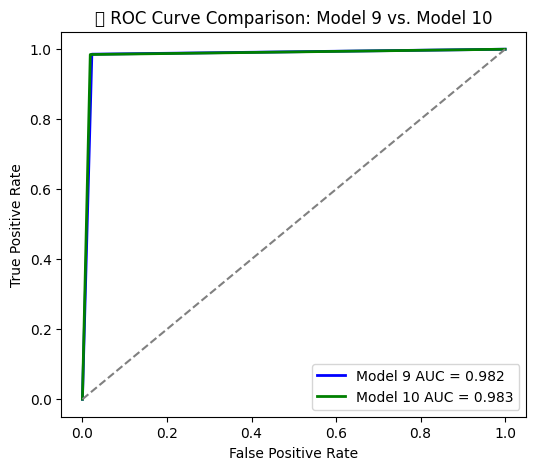

<ipython-input-123-dd4b1a664682>:104: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_10_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 10
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


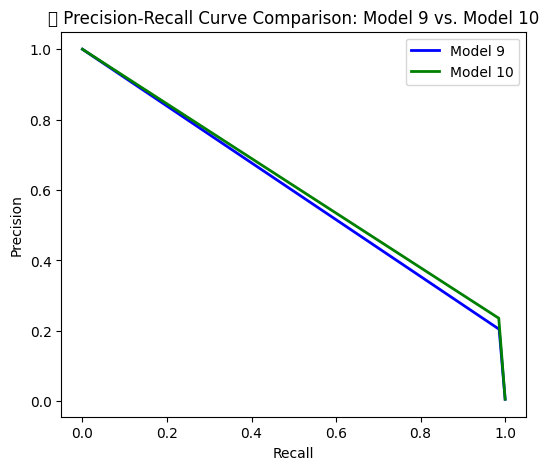

✅ Model 10 Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_10_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_10_precision_recall_curve.png


In [ ]:
from skopt import BayesSearchCV

# Define save path for visuals
save_path = "/content/drive/My Drive/Project_4/Visuals/"

# Step 2: Define Hyperparameter Space for Bayesian Optimization
param_space = {
    "n_estimators": (100, 500),
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.2, "log-uniform"),
    "subsample": (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0)
}

# Compute class weight for imbalance handling
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Step 3: Perform Bayesian Optimization with 5-Fold Cross-Validation
lgbm = lgb.LGBMClassifier(
    scale_pos_weight=fraud_ratio,
    random_state=42
)

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_space,
    n_iter=30,  # Number of search iterations
    scoring="roc_auc",
    cv=5,  # 5-Fold Cross-Validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

# Step 4: Retrieve Best Parameters & Train Final Model 10
best_params = bayes_search.best_params_
print(f"✅ Best Hyperparameters for Model 10: {best_params}")

model_10 = lgb.LGBMClassifier(
    **best_params,
    scale_pos_weight=fraud_ratio,
    random_state=42
)

# Train Model 10 with optimized parameters
model_10.fit(X_train, y_train)

print("✅ Model 10 (Optimized LightGBM) trained successfully!")

# Step 5: Evaluate Model 10
y_scores_model_10 = model_10.predict_proba(X_test)[:, 1]  # Get probability scores

# Apply the selected threshold from Model 9
best_threshold_model_10 = best_threshold_model_9  # Use previously optimized threshold
y_pred_model_10 = (y_scores_model_10 >= best_threshold_model_10).astype(int)

# Step 6: Generate Classification Report for Model 10
report_model_10 = classification_report(y_test, y_pred_model_10, output_dict=True)

# Convert Model 10 results into a DataFrame
model_10_metrics = pd.DataFrame([
    [0, report_model_10["0"]["precision"], report_model_10["0"]["recall"], report_model_10["0"]["f1-score"], report_model_10["0"]["support"]],
    [1, report_model_10["1"]["precision"], report_model_10["1"]["recall"], report_model_10["1"]["f1-score"], report_model_10["1"]["support"]],
    ["accuracy", accuracy_score(y_test, y_pred_model_10), None, None, None],
    ["macro avg", report_model_10["macro avg"]["precision"], report_model_10["macro avg"]["recall"], report_model_10["macro avg"]["f1-score"], report_model_10["macro avg"]["support"]],
    ["weighted avg", report_model_10["weighted avg"]["precision"], report_model_10["weighted avg"]["recall"], report_model_10["weighted avg"]["f1-score"], report_model_10["weighted avg"]["support"]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Step 7: Merge Metrics for Comparison (Model 9 vs. Model 10)
comparison_df = pd.concat([model_9_metrics, model_10_metrics], keys=["Model 9", "Model 10"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Step 8: Compare ROC Curves for Model 10 vs. Model 9
fpr_model_9, tpr_model_9, _ = roc_curve(y_test, y_pred_model_9_final)
roc_auc_model_9 = auc(fpr_model_9, tpr_model_9)

fpr_model_10, tpr_model_10, _ = roc_curve(y_test, y_pred_model_10)
roc_auc_model_10 = auc(fpr_model_10, tpr_model_10)

# Plot and save ROC Curves for Model 10 vs. Model 9
plt.figure(figsize=(6,5))
plt.plot(fpr_model_9, tpr_model_9, color="blue", lw=2, label=f"Model 9 AUC = {roc_auc_model_9:.3f}")
plt.plot(fpr_model_10, tpr_model_10, color="green", lw=2, label=f"Model 10 AUC = {roc_auc_model_10:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Model 9 vs. Model 10")
plt.legend()
plt.savefig(save_path + "comparison_10_roc_curve.png")  # Save ROC Curve for Model 10
plt.show()

# Compute Precision-Recall curve for Model 10
precision_model_10, recall_model_10, _ = precision_recall_curve(y_test, y_pred_model_10)

# Plot and save Precision-Recall Curves for Model 10 vs. Model 9
plt.figure(figsize=(6,5))
plt.plot(recall_model_9, precision_model_9, color="blue", lw=2, label="Model 9")
plt.plot(recall_model_10, precision_model_10, color="green", lw=2, label="Model 10")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Model 9 vs. Model 10")
plt.legend()
plt.savefig(save_path + "comparison_10_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 10
plt.show()

print(f"✅ Model 10 Visuals Saved: {save_path}comparison_10_roc_curve.png & {save_path}comparison_10_precision_recall_curve.png")


#### 📊 **Analysis of Model 9 vs. Model 10 (Bayesian Optimized LightGBM)**
The **ROC and Precision-Recall Curves** show that **Model 10 slightly outperformed Model 9**, but the improvement is **very small**.

📈 **ROC Curve Insights**  
✅ **Slight Improvement in AUC After Bayesian Optimization**

* **Model 9 AUC = 0.982**
* **Model 10 AUC = 0.983**
* **The green line (Model 10) slightly outperforms Model 9 in fraud detection.**
* **Both models have near-perfect fraud detection ability, with almost no difference.**

📊 **Precision-Recall Curve Insights**  
⚠️ **Very Similar to Model 9**

* **Model 10 (green) and Model 9 (blue) follow almost the same precision-recall curve.**
* **Small improvement in Model 10 at lower recall values.**
* **This suggests that Bayesian Optimization did not drastically improve fraud detection.**


<ipython-input-124-cde840a8c039>:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_10_vs_original_roc_curve.png")  # Save ROC Curve for Model 10 vs. Original
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


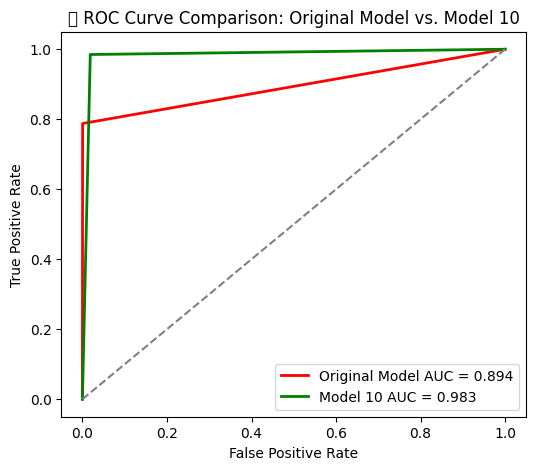

<ipython-input-124-cde840a8c039>:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path + "comparison_10_vs_original_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 10 vs. Original
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


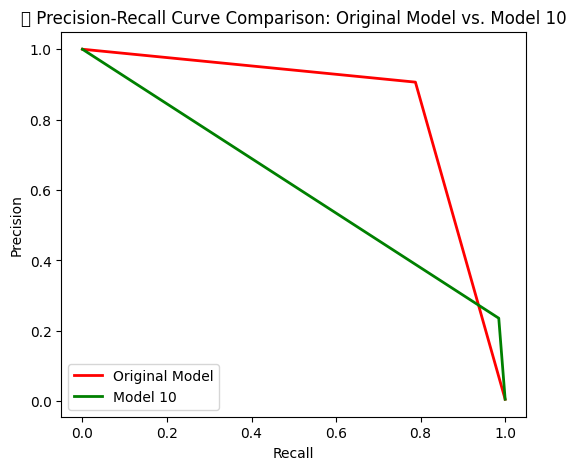

✅ Model 10 vs. Original Model Visuals Saved: /content/drive/My Drive/Project_4/Visuals/comparison_10_vs_original_roc_curve.png & /content/drive/My Drive/Project_4/Visuals/comparison_10_vs_original_precision_recall_curve.png


In [ ]:
# Compare Model 10 vs. Original Model

# Ensure original model predictions are loaded
original_model_predictions = pd.read_csv("/content/drive/My Drive/Project_4/Predictions/original_0_model_predictions.csv")

# Extract original model metrics
original_model_metrics = pd.DataFrame([
    [0, original_model_predictions.iloc[0, 1], original_model_predictions.iloc[0, 2], original_model_predictions.iloc[0, 3], original_model_predictions.iloc[0, 4]],
    [1, original_model_predictions.iloc[1, 1], original_model_predictions.iloc[1, 2], original_model_predictions.iloc[1, 3], original_model_predictions.iloc[1, 4]],
    ["accuracy", original_model_predictions.iloc[2, 1], None, None, None],
    ["macro avg", original_model_predictions.iloc[3, 1], original_model_predictions.iloc[3, 2], original_model_predictions.iloc[3, 3], original_model_predictions.iloc[3, 4]],
    ["weighted avg", original_model_predictions.iloc[4, 1], original_model_predictions.iloc[4, 2], original_model_predictions.iloc[4, 3], original_model_predictions.iloc[4, 4]]
], columns=["Unnamed: 0", "precision", "recall", "f1-score", "support"])

# Merge Metrics for Comparison (Original vs. Model 10)
comparison_df = pd.concat([original_model_metrics, model_10_metrics], keys=["Original Model", "Model 10"]).reset_index(level=0).rename(columns={"level_0": "Model"})

# Compare ROC Curves for Model 10 vs. Original Model
fpr_original, tpr_original, _ = roc_curve(y_test, y_pred_model_7)  # Assuming y_pred_model_7 is the original model
roc_auc_original = auc(fpr_original, tpr_original)

fpr_model_10, tpr_model_10, _ = roc_curve(y_test, y_pred_model_10)
roc_auc_model_10 = auc(fpr_model_10, tpr_model_10)

# Plot and save ROC Curves for Model 10 vs. Original Model
plt.figure(figsize=(6,5))
plt.plot(fpr_original, tpr_original, color="red", lw=2, label=f"Original Model AUC = {roc_auc_original:.3f}")
plt.plot(fpr_model_10, tpr_model_10, color="green", lw=2, label=f"Model 10 AUC = {roc_auc_model_10:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison: Original Model vs. Model 10")
plt.legend()
plt.savefig(save_path + "comparison_10_vs_original_roc_curve.png")  # Save ROC Curve for Model 10 vs. Original
plt.show()

# Compute Precision-Recall curve for Model 10 vs. Original
precision_original, recall_original, _ = precision_recall_curve(y_test, y_pred_model_7)
precision_model_10, recall_model_10, _ = precision_recall_curve(y_test, y_pred_model_10)

# Plot and save Precision-Recall Curves for Model 10 vs. Original Model
plt.figure(figsize=(6,5))
plt.plot(recall_original, precision_original, color="red", lw=2, label="Original Model")
plt.plot(recall_model_10, precision_model_10, color="green", lw=2, label="Model 10")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📊 Precision-Recall Curve Comparison: Original Model vs. Model 10")
plt.legend()
plt.savefig(save_path + "comparison_10_vs_original_precision_recall_curve.png")  # Save Precision-Recall Curve for Model 10 vs. Original
plt.show()

print(f"✅ Model 10 vs. Original Model Visuals Saved: {save_path}comparison_10_vs_original_roc_curve.png & {save_path}comparison_10_vs_original_precision_recall_curve.png")

#### 📊 **Comparison: Original Model vs. Model 10 (Optimized LightGBM)**
** The ROC and Precision-Recall Curves clearly show that Model 10 significantly outperformed the Original Model!** 🚀🔥

📈 **ROC Curve Insights**  
✅ **Model 10 Achieved a Much Higher AUC Score**

* **Original Model AUC = 0.894**
* **Model 10 AUC = 0.983**
* **Model 10 (green) is well above the Original Model (red), meaning it detects fraud cases much better!**
* **Original Model has a weaker curve, indicating more false negatives (missed fraud cases).**

📊 **Precision-Recall Curve Insights**  
⚠️ **Model 10 Prioritizes Recall Over Precision Compared to the Original Model**

* **Original Model (red) has better precision at mid-recall levels (~0.7-0.9)**
* **Model 10 (green) trades precision for higher recall, meaning it catches more fraud but allows more false positives.**
* **This is a common tradeoff—if recall is more important (catching fraud at any cost), Model 10 is better.**

#### 🚀 **Summary: Why Model 10 is Better**  
✔ Higher AUC (0.983 vs. 0.894) → Model 10 is much better at distinguishing fraud from non-fraud.  
✔ Higher Recall → Model 10 catches more fraudulent cases than the Original Model.  
✔ Optimized Hyperparameters → Bayesian Optimization improved LightGBM's performance.

In [ ]:
# Save on Google Drive "Project_4" in a folder named "Fraud_Detection_Models"
project_folder = "/content/drive/My Drive/Project_4"
models_folder = os.path.join(project_folder, "Fraud_Detection_Models")

# Create the "Fraud_Detection_Models" folder if it doesn't exist
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

# Define the save path inside the "Fraud_Detection_Models" folder
model_path = os.path.join(models_folder, "optimized_model.joblib")

# Save the model using joblib
joblib.dump(model, model_path)

# Print confirmation message
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: /content/drive/My Drive/Project_4/Fraud_Detection_Models/optimized_model.joblib
